# The basics of using IQM Resonance

You will have free access to IQM's cloud quantum computing platform, IQM Resonance, during this hackathon.

In this notebook, you will see how to connect to IQM Resonance and how to manage your jobs in different frameworks. For each framework, where these features are supported, you will learn to:
- Connect to Resonance
- Submit a job
- Submit several circuits in the same job
- Retrieve jobs you have already finished

The frameworks currently listed in this tutorial are:
- Qrisp
- CUDA-Q
- Qiskit
- Cirq

You are welcome to use any of them for this challenge, or any other framework that supports IQM Resonance as a backend.

If you run into any problems (there are lots of things that can go wrong here!), please get in touch with an IQM mentor.

# Setting up your Python environment to use IQM Resonance

You will need to set up a **Python 3.11 or 3.12** runtime environment, neither of which is the most recent Python version, with the appropriate packages installed. You will need to either:
- Install one of these Python versions from the Python website
- Set up a conda or other virtual environment in one of these versions
- Run your code via qBraid (see the qBraid tutorial from Friday)
- Run your code via Google Colab, in which case you should change the runtime type to 2025.07.

If you are using CUDA-Q, we recommend using qBraid, although Google Colab will also work fine.

# Making an IQM Resonance account and an API token

In order to connect to IQM Resonance, you will need an account and an API token. Your API token is a string, unique to you, that associates any jobs you submit to you account. Your API token is required to submit a job to Resonance.

### Create your account

Use [this link](https://resonance.meetiqm.com/sign-up/iquhack26-iqm%20challenge) to create your account. This link should give you plenty of credits to complete the challenge.

### Creating your API token

To create your API token,

1) Go to [the Resonance website](resonance.meetiqm.com) and log in.
2) Click your initials in the upper right corner.
3) In the menu that pops up, under "API token", click the circular arrows.
4) You will now see your API token. Copy it somewhere safe!

### Using your API token

Your API token will work for every job you submit until the expiration date listed on the Resonance website. In the code snippets below where we submit jobs to Resonance, just copy-paste your API token when prompted.

### I lost or gave away my API token! Now what?

If you ever lose your API token (or if someone else gets your API token), you can make a new one by repeating the steps in "Creating your API token." This will cause your old API token to stop working.

# Submitting jobs to Resonance

Scroll to your preferred framework to see how to submit jobs to Resonance.

## Qrisp

Install required packages:

In [ ]:
!pip install --upgrade pip
!pip install iqm-client
!pip install "qrisp[iqm]"

Build a simple quantum circuit:

In [ ]:
from qrisp import *

qv = QuantumVariable(3)
h(qv[0])
cx(qv[0], qv[1])
cx(qv[0], qv[2])

print(qv.qs)

QuantumCircuit:
---------------
      ┌───┐          
qv.0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
qv.1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
qv.2: ──────────┤ X ├
                └───┘
Live QuantumVariables:
----------------------
QuantumVariable qv


Connect to Resonance and submit the job:

In [ ]:
from qrisp.interface import IQMBackend
quantum_computer = IQMBackend(
    api_token = input("IQM Resonance API token"),
        device_instance = "garnet") # Change this to change which device you run on

results = qv.get_measurement(backend=quantum_computer)

print(results)

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

{'000': 0.477, '111': 0.464, '110': 0.019, '001': 0.015, '101': 0.01, '010': 0.008, '011': 0.005, '100': 0.002}


Submit several circuits in a single job:

In [ ]:
import numpy as np
circuits = []

num_circuits=5
phases = [2*np.pi*x/num_circuits for x in range(num_circuits) ]

circuit_list = []
for phase in phases:
    qv = QuantumVariable(1)
    # Create a quantum circuit that applies a Hadamard, a phase gate, and another Hadamard to a single qubit
    h(qv)
    p(phase,qv)
    h(qv)
    circuit_list.append(qv)

#show a circuit as an example
print(circuit_list[2].qs)

jobs = batched_measurement(circuit_list, backend=quantum_computer)

QuantumCircuit:
---------------
      ┌───┐┌─────────┐┌───┐
qv.0: ┤ H ├┤ P(4π/5) ├┤ H ├
      └───┘└─────────┘└───┘
Live QuantumVariables:
----------------------
QuantumVariable qv


Progress in queue:   0%|          | 0/17 [00:00<?, ?it/s]

Retrieve the measurement results:

In [ ]:
for job in jobs:
    print(job)

{'0': 0.983, '1': 0.017}
{'0': 0.637, '1': 0.363}
{'1': 0.876, '0': 0.124}
{'1': 0.882, '0': 0.118}
{'0': 0.659, '1': 0.341}


As of December 2025, retrieving a job via job ID is not supported in qrisp.

# CUDA-Q

Note that CUDA-Q does not support Star topology devices, in particular Sirius is not supported.

Install required packages:

In [ ]:
!pip install cudaq
!pip install iqm-cortex-cli

Build a simple quantum circuit:

In [ ]:
import cudaq

@cudaq.kernel
def simpleCircuit():
    qubits = cudaq.qvector(3)
    h(qubits[0])
    x.ctrl(qubits[0],qubits[1])
    x.ctrl(qubits[0],qubits[2])
    mz(qubits)

Connect to IQM Resonance and submit the job:

In [ ]:
import os

os.environ["IQM_TOKEN"] = input("Input your Resonance API token: ")

iqm_url = "https://cocos.resonance.meetiqm.com/emerald" # You can change Emerald to other machines if you want!

cudaq.set_target("iqm", url=iqm_url)

result = cudaq.sample(simpleCircuit)

Submit several circuits to retrieve later (without restarting your runtime):

In [ ]:
import numpy as np

num_circuits=5
phases = [2*np.pi*x/num_circuits for x in range(num_circuits) ]

job_list = []
@cudaq.kernel
def phaseCircuit(phase:float):
    qubit = cudaq.qubit()
    # Create a quantum circuit that applies a Hadamard, a phase gate, and another Hadamard to a single qubit    qc.h(0)
    h(qubit)
    rz(phase,qubit)
    h(qubit)
    mz(qubit)

for phase in phases:
    job_list.append(cudaq.sample_async(phaseCircuit, phase))

Retrieve the jobs:

In [ ]:
for job in job_list:
    print(job.get())

As of January 2026, neither batched jobs nor retrieving a job via job ID are supported in CUDA-Q.

# Qiskit

Install required packages:

In [ ]:
!pip install "iqm-client[qiskit]"

Build a simple quantum circuit:

In [ ]:
from qiskit import *

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.measure_all()

Connect to IQM Resonance and submit the job:

In [ ]:
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token=input("Input your IQM Resonance token"))
backend = provider.get_backend()

qc_transpiled = transpile(qc,backend)
job = backend.run(qc_transpiled)

results=job.result()
print(results.get_counts())

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

{'000': 466, '111': 392, '101': 34, '110': 23, '001': 30, '100': 33, '011': 34, '010': 12}


Submit several circuits in a single job:

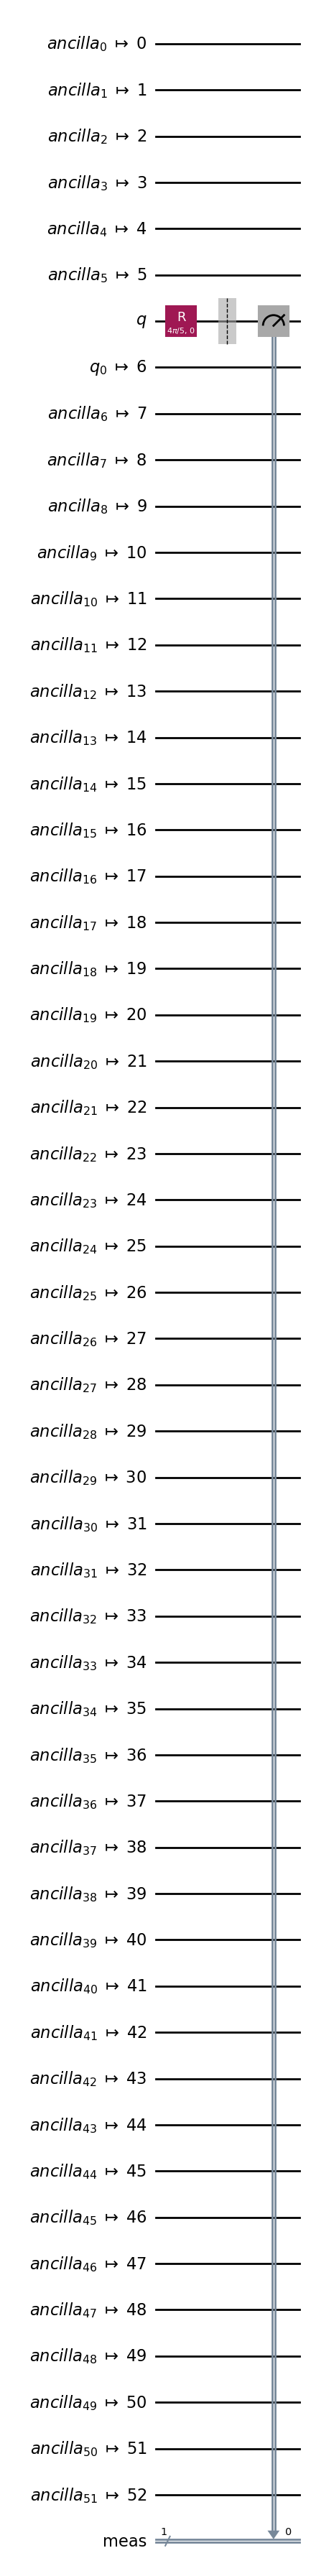

In [ ]:
import numpy as np
circuits = []

num_circuits=5
phases = [2*np.pi*x/num_circuits for x in range(num_circuits) ]

circuit_list = []
for phase in phases:
    qc = QuantumCircuit(1)
    # Create a quantum circuit that applies a Hadamard, a phase gate, and another Hadamard to a single qubit    qc.h(0)
    qc.h(0)
    qc.p(phase,0)
    qc.h(0)
    qc.measure_all()
    qc_transpiled = qc.transpile(backend=backend) # Get the circuit ready for IQM hardware
    circuit_list.append(qc_transpiled)

#show a circuit as an example
circuit_list[2].draw("mpl")

jobs = backend.run(circuit_list)

Retrieve the jobs:

NOTE: If you restarted your runtime after submitting the job, you need the Resonance job ID. It can be obtained as shown below, or, if you click on the job in your list of Resonance jobs, it is the long hexadecimal string at the top of the pop-up window. (Note: in the list of jobs, you will see a 6-character job ID. This is not the full job ID! You need the 32-character (plus hyphens) job ID.)

In [ ]:
# When working in the same runtime:
print(jobs.result().get_counts())

# Or you can use the job ID, even if you restarted the runtime:
job_id = jobs.job_id()  # For this notebook we're getting the job ID this way,
                        # but you can get it from your list of past jobs in Resonance
print(job_id)

retrieved_job = backend.retrieve_job(job_id)

print(retrieved_job.result().get_counts())

[{'0': 991, '1': 33}, {'0': 675, '1': 349}, {'1': 910, '0': 114}, {'0': 148, '1': 876}, {'0': 657, '1': 367}]
019b36bc-654d-77d2-99a0-1a1d6c320164
[{'0': 991, '1': 33}, {'0': 675, '1': 349}, {'1': 910, '0': 114}, {'0': 148, '1': 876}, {'0': 657, '1': 367}]


# Cirq

Install required packages:

In [ ]:
!pip install iqm-client[cirq]

Connect to IQMResonance (Note: there are several ways to build the circuit in Cirq. One way is to use arbitrary qubits that don't depend on the backend, but it's a little simpler to use backend-specific qubits instead. In order to do this, we cannot build the circuit before connecting to the backend.)

In [ ]:
from iqm.cirq_iqm.iqm_sampler import IQMSampler

server_url = "https://resonance.meetiqm.com/"
sampler=IQMSampler(server_url,
                   quantum_computer="emerald",
                   token=input("Input your IQM Resonance token"))

Build a simple circuit

In [ ]:
import cirq

qubits = sampler.device.qubits[:3]

circuit = cirq.Circuit()

circuit.append(cirq.H(qubits[0]))

for qb in qubits[1:]:
    circuit.append(cirq.CNOT(qubits[0],qb))

circuit.append(cirq.measure(*qubits, key='result'))

Run the circuit:

In [ ]:
routed_circuit, _, _ = sampler.device.route_circuit(circuit)

decomposed_circuit = sampler.device.decompose_circuit(routed_circuit)

from iqm.cirq_iqm.optimizers import simplify_circuit
simplified_circuit = simplify_circuit(decomposed_circuit)

print(simplified_circuit)

shots=1000
result = sampler.run(simplified_circuit, repetitions=shots)

print(result.histogram(key='result'))

QB11 (d=2): ───PhX(-0.5)^0.5───────@──────────────PhX(0.5)^0.5───M─────────────
                                   │                             │
QB19 (d=2): ───PhX(-0.5)^0.5───@───@─────────────────────────────M('result')───
                               │                                 │
QB27 (d=2): ───PhX(-0.5)^0.5───@───PhX(0.5)^0.5──────────────────M─────────────


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Counter({0: 465, 7: 388, 6: 46, 3: 29, 1: 28, 2: 22, 5: 12, 4: 10})


Submit several circuits in a single job:

In [ ]:
import numpy as np
circuits = []

num_circuits=5
phases = [2*np.pi*x/num_circuits for x in range(num_circuits) ]

circuit_list = []
for phase in phases:
    qubit = sampler.device.qubits[:1]
    # Create a quantum circuit that applies a Hadamard, a phase gate, and another Hadamard to a single qubit
    c = cirq.Circuit(
        cirq.H(qubit[0]),
        cirq.rz(phase)(qubit[0]),
        cirq.H(qubit[0]),
        cirq.measure(*qubit,key="result")
    )
    routed_c, _, _ = sampler.device.route_circuit(c)
    decomposed_c = sampler.device.decompose_circuit(routed_c)
    simplified_c = simplify_circuit(decomposed_c)
    circuit_list.append(simplified_c)

#show a circuit as an example
print(circuit_list[2])

shots=1000
result = sampler.run_iqm_batch(circuit_list, repetitions=shots)

for res in result:
    print(res.histogram(key="result") )

QB27 (d=2): ───PhX(0)^0.8───M('result')───
Counter({0: 968, 1: 32})
Counter({0: 617, 1: 383})
Counter({1: 868, 0: 132})
Counter({1: 860, 0: 140})
Counter({0: 642, 1: 358})


As of December 2025, retrieving jobs via their job ID is not supported in Cirq.